In [1]:
import numpy as np
import pandas as pd
import pickle
from scipy import stats
from pathlib import Path
from sklearn.datasets import load_svmlight_file, dump_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

import local_pkg_path
import counterfactual_evaluation as cfeval

### Simulatiing clicks

In [2]:
fold = 'Fold1'

In [3]:
sim_exp_train_vali_rankings = pd.read_csv(f'../build/simulation/{fold}/sim_exp_train_vali_rankings.csv')

In [4]:
sim_exp_train_vali_rankings.head()

,partition,qid,0,1,2,3,4,5,6,7,...,130,131,132,133,134,135,y,rank,pred_rank,pred_score
0,train,1,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,57017.0,11.0,26.0,138.0,0.0,0.0,1,0,9.0,1018.293457
1,train,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,65535.0,4.0,1.0,0.0,0.0,0.0,1,1,8.0,1271.880859
2,train,1,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,65535.0,3.0,1.0,0.0,0.0,0.0,1,2,7.0,1502.562744
3,train,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,65535.0,3.0,1.0,0.0,0.0,0.0,1,3,5.0,3109.371582
4,train,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,65535.0,2.0,1.0,0.0,0.0,0.0,1,4,4.0,3295.381836


Normalize features

In [5]:
feature_columns = [str(x) for x in range(136)]

In [6]:
X = sim_exp_train_vali_rankings[feature_columns].values
y = sim_exp_train_vali_rankings['y'].values

In [7]:
examination_feature_scaler = preprocessing.StandardScaler().fit(X)
X_normed = examination_feature_scaler.transform(X)

Select top-10 import features

In [8]:
from xgboost import XGBRFRegressor

rfr = XGBRFRegressor(n_estimators=500, max_depth=10, objective='reg:squarederror', n_jobs=64)
rfr.fit(X_normed, y)

XGBRFRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=0.8, colsample_bytree=1, gamma=0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=1, max_delta_step=0, max_depth=10,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=500, n_jobs=64, num_parallel_tree=500,
               objective='reg:squarederror', random_state=0, reg_alpha=0,
               reg_lambda=1e-05, scale_pos_weight=1, subsample=0.8,
               tree_method='exact', validate_parameters=1, verbosity=None)

In [9]:
examination_fc = np.sort(np.flip(np.argsort(rfr.feature_importances_))[:10])

In [10]:
examination_fc = np.array(feature_columns)[examination_fc]

In [11]:
with open(f'../build/simulation/{fold}/examination_fc_names.pkl', 'wb') as f:
    print(f'Dumping examination feature columns {examination_fc}')
    pickle.dump(examination_fc, f)

Dumping examination feature columns ['53' '54' '63' '99' '103' '106' '108' '126' '129' '133']


In [12]:
pd.DataFrame({'feature_column_names': examination_fc}).to_csv(f'../build/simulation/{fold}/examination_fc_names.csv')

Click model

In [13]:
examination_nf = 10
eta = 1
noise_eps = dict([(0, 0.1), (1, 1.0)])
noise_model = cfeval.simulator.ClickNoise(noise_eps)
examination_model = cfeval.simulator.ContextualPositionExamination(eta, examination_nf)
click_model = cfeval.simulator.PositionBasedClickModel(examination_model, noise_model)

In [14]:
click_model.examination.weights

array([ 0.1464472 ,  0.4851479 , -0.09454306, -0.40682657,  0.59000454,
       -0.2199528 ,  0.57765299, -1.07955507, -0.6735567 ,  0.67518158])

In [15]:
weights = examination_model.weights

In [16]:
weights

array([ 0.1464472 ,  0.4851479 , -0.09454306, -0.40682657,  0.59000454,
       -0.2199528 ,  0.57765299, -1.07955507, -0.6735567 ,  0.67518158])

In [17]:
with open(f'../build/simulation/{fold}/examination_weights.pkl', 'wb') as f:
    pickle.dump(weights, f)

In [18]:
def generate_clicks(sample_rankings, rank_column, rel_column, click_model, feature_columns, scaler=None):
    context = sample_rankings[feature_columns].values
    if scaler is not None:
        context = scaler.transform(context)
    sample_clicks = click_model.values(sample_rankings[rank_column].values, sample_rankings[rel_column].values, context=context)
    sample_rankings['click'] = sample_clicks
    sample_rankings['true_click_probability'] = click_model.probabilities(sample_rankings[rank_column].values, sample_rankings[rel_column].values, context=context)
    sample_rankings['true_propensity'] = click_model.examination.probabilities(sample_rankings[rank_column].values, context=context)
    sample_rankings['inverse_true_propensity'] = 1 / sample_rankings['true_propensity']
    return sample_rankings

In [19]:
def swap_ranks(data, id_column, rank_column, swap_dict, anchor_rank):
    def _swap_rank(row):
        rank_to_swap = swap_dict.get(row[id_column])
        curr_rank = row[rank_column]
        if (curr_rank != anchor_rank) and (curr_rank != rank_to_swap):
            return curr_rank
        if curr_rank == anchor_rank:
            return rank_to_swap
        if curr_rank == rank_to_swap:
            return anchor_rank
    return data.apply(_swap_rank, axis=1)

In [20]:
def sample_rows_by(data, by, sampling_fn):
    unique_values = data[by].unique()
    samples = pd.DataFrame({by: sampling_fn(unique_values)})
    samples['list_id'] = np.arange(1, len(samples) + 1)
    return samples.merge(data, on=by, how='left')

In [21]:
def uniform_sample(arr, times=5):
    size = len(arr) * times
    return np.random.choice(arr, size=size)

In [22]:
sim_exp_train_vali_rankings.head()

,partition,qid,0,1,2,3,4,5,6,7,...,130,131,132,133,134,135,y,rank,pred_rank,pred_score
0,train,1,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,57017.0,11.0,26.0,138.0,0.0,0.0,1,0,9.0,1018.293457
1,train,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,65535.0,4.0,1.0,0.0,0.0,0.0,1,1,8.0,1271.880859
2,train,1,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,65535.0,3.0,1.0,0.0,0.0,0.0,1,2,7.0,1502.562744
3,train,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,65535.0,3.0,1.0,0.0,0.0,0.0,1,3,5.0,3109.371582
4,train,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,65535.0,2.0,1.0,0.0,0.0,0.0,1,4,4.0,3295.381836


In [23]:
sim_exp_train_vali_rankings.drop('rank', axis=1, inplace=True)

In [24]:
sim_exp_train_vali_rankings['qd_id'] = np.arange(sim_exp_train_vali_rankings.shape[0])

In [25]:
examination_X = sim_exp_train_vali_rankings[examination_fc].values
examination_feature_scaler = preprocessing.StandardScaler().fit(examination_X)
examination_X_normed = examination_feature_scaler.transform(examination_X)

In [26]:
sim_exp_train_vali_rankings_feature_examination = sim_exp_train_vali_rankings[['partition', *examination_fc, 'y', 'qd_id', 'qid', 'pred_rank', 'pred_score']]

In [27]:
examination_features = sim_exp_train_vali_rankings[['partition', *examination_fc, 'qd_id']].copy()

In [28]:
examination_features.head()

,partition,53,54,63,99,103,106,108,126,129,133,qd_id
0,train,0.166667,0.037576,0.166667,1.0,1.0,0.000000,13.645480,30.0,3727.0,138.0,0
1,train,0.125000,0.060862,0.125000,1.0,1.0,12.536522,11.755208,44.0,6217.0,0.0,1
2,train,0.125000,0.061333,0.125000,1.0,1.0,0.000000,11.755208,43.0,8681.0,0.0,2
3,train,0.142857,0.042008,0.142857,1.0,1.0,19.276589,12.630009,42.0,22282.0,0.0,3
4,train,0.111111,0.025709,0.111111,1.0,1.0,19.571210,10.993742,46.0,22883.0,0.0,4


In [29]:
examination_features[examination_fc] = examination_X_normed

In [30]:
examination_features.head()

,partition,53,54,63,99,103,106,108,126,129,133,qd_id
0,train,1.976927,0.453423,1.764048,0.607835,1.511765,-0.373532,1.048441,-0.460300,-0.809199,-0.029974,0
1,train,1.364728,1.090312,1.155011,0.607835,1.511765,1.802201,0.800594,0.178776,-0.705149,-0.036124,1
2,train,1.364728,1.103194,1.155011,0.607835,1.511765,-0.373532,0.800594,0.133128,-0.602185,-0.036124,2
3,train,1.627095,0.574641,1.416023,0.607835,1.511765,2.971950,0.915295,0.087480,-0.033838,-0.036124,3
4,train,1.160662,0.128851,0.951999,0.607835,1.511765,3.023082,0.700753,0.270073,-0.008724,-0.036124,4


In [31]:
examination_features.to_csv(f'../build/simulation/{fold}/examination_features.csv', index=False)

In [32]:
sim_exp_ltr_features = sim_exp_train_vali_rankings[['partition', *feature_columns, 'qd_id']].copy()
sim_exp_ltr_features.to_csv(f'../build/simulation/{fold}/sim_exp_ltr_features.csv', index=False)

In [33]:
sample_rankings = sample_rows_by(sim_exp_train_vali_rankings, by='qid', sampling_fn=lambda x: uniform_sample(x, 5))
swap_rank_range = 10
list_ids = sample_rankings['list_id'].unique()
size = len(list_ids)
swap_dict = dict(zip(list_ids, np.random.randint(1, swap_rank_range + 1, size=size)))
sample_rankings['swapped_rank'] = swap_ranks(sample_rankings, 'list_id', 'pred_rank', swap_dict, 1)
assert all(sample_rankings[sample_rankings['pred_rank']==1]['swapped_rank'].values == np.array(list(swap_dict.values())))
sample_rankings = generate_clicks(sample_rankings, 'swapped_rank', 'y', click_model, examination_fc, scaler=examination_feature_scaler)

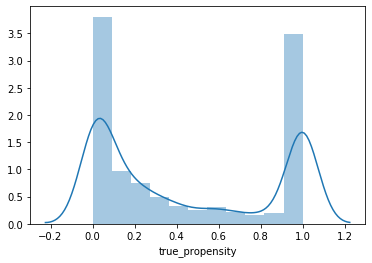

In [34]:
sns.distplot(sample_rankings[sample_rankings['y']==1]['true_propensity'])

In [35]:
sample_rankings[sample_rankings['y']==1].head()

,qid,list_id,partition,0,1,2,3,4,5,6,...,135,y,pred_rank,pred_score,qd_id,swapped_rank,click,true_click_probability,true_propensity,inverse_true_propensity
0,91,1,train,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,1,7.0,5346.999023,900,7.0,0,0.096621,0.096621,10.349746
2,91,1,train,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,1,9.0,3314.630371,902,9.0,0,0.007377,0.007377,135.554347
3,91,1,train,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,1,8.0,4874.604980,903,8.0,0,0.031463,0.031463,31.783635
4,91,1,train,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,1,6.0,6132.371094,904,6.0,1,0.097982,0.097982,10.205948
5,91,1,train,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1,5.0,6898.436523,905,5.0,0,0.097652,0.097652,10.240405


In [36]:
sim_exp_train_vali_rankings_feature_examination.head()

,partition,53,54,63,99,103,106,108,126,129,133,y,qd_id,qid,pred_rank,pred_score
0,train,0.166667,0.037576,0.166667,1.0,1.0,0.000000,13.645480,30.0,3727.0,138.0,1,0,1,9.0,1018.293457
1,train,0.125000,0.060862,0.125000,1.0,1.0,12.536522,11.755208,44.0,6217.0,0.0,1,1,1,8.0,1271.880859
2,train,0.125000,0.061333,0.125000,1.0,1.0,0.000000,11.755208,43.0,8681.0,0.0,1,2,1,7.0,1502.562744
3,train,0.142857,0.042008,0.142857,1.0,1.0,19.276589,12.630009,42.0,22282.0,0.0,1,3,1,5.0,3109.371582
4,train,0.111111,0.025709,0.111111,1.0,1.0,19.571210,10.993742,46.0,22883.0,0.0,1,4,1,4.0,3295.381836


In [37]:
swap_rank_range = 10
anchor_rank = 1
for avg_clicks in [5, 10, 25, 50]:
    sample_rankings = sample_rows_by(sim_exp_train_vali_rankings_feature_examination, by='qid', 
                                     sampling_fn=lambda x: uniform_sample(x, avg_clicks))
    print(f'generate ltr clicks with avg clicks {avg_clicks}')
    sample_rankings['swapped_rank'] = sample_rankings['pred_rank'].values
    sample_rankings = generate_clicks(sample_rankings, 'swapped_rank', 'y', 
                                      click_model, examination_fc, scaler=examination_feature_scaler)
    print('Dumping ltr clicks')
    sample_rankings.drop(examination_fc, axis=1).to_csv(f'../build/simulation/{fold}/sim_exp_ltr_train_vali_clicks_avg_clicks_{avg_clicks}.csv', index=False)
    print(f'generate swap experiment clicks with avg clicks {avg_clicks}')
    list_ids = sample_rankings['list_id'].unique()
    size = len(list_ids)
    swap_dict = dict(zip(list_ids, np.random.randint(1, swap_rank_range + 1, size=size)))
    sample_rankings['swapped_rank'] = swap_ranks(sample_rankings, 'list_id', 'pred_rank', swap_dict, anchor_rank)
    assert all(sample_rankings[sample_rankings['pred_rank']==anchor_rank]['swapped_rank'].values == np.array(list(swap_dict.values())))
    sample_rankings = generate_clicks(sample_rankings, 'swapped_rank', 'y', 
                                      click_model, examination_fc, scaler=examination_feature_scaler)
    print('Dumping swap experiment clicks')
    sample_rankings.drop(examination_fc, axis=1).to_csv(f'../build/simulation/{fold}/sim_exp_swap_train_vali_clicks_avg_clicks_{avg_clicks}.csv', index=False)

generate ltr clicks with avg clicks 5
Dumping ltr clicks
generate swap experiment clicks with avg clicks 5
Dumping swap experiment clicks
generate ltr clicks with avg clicks 10
Dumping ltr clicks
generate swap experiment clicks with avg clicks 10
Dumping swap experiment clicks
generate ltr clicks with avg clicks 25
Dumping ltr clicks
generate swap experiment clicks with avg clicks 25
Dumping swap experiment clicks
generate ltr clicks with avg clicks 50
Dumping ltr clicks
generate swap experiment clicks with avg clicks 50
Dumping swap experiment clicks


In [38]:
sample_rankings.groupby(['qid']).size().describe()

count    381.000000
mean     499.062992
std       69.879115
min      153.000000
25%      460.000000
50%      500.000000
75%      550.000000
max      680.000000
dtype: float64

In [39]:
sample_rankings.groupby(['qid', 'qd_id', 'swapped_rank']).agg({'click': ['mean', 'count'], 
                                                               'true_click_probability': ['max', 'min']})

click       true_click_probability          
                            mean count                    max       min
qid qd_id swapped_rank                                                 
1   0     1.0           1.000000     3               1.000000  1.000000
          9.0           0.000000    47               0.000297  0.000297
    1     1.0           1.000000     2               1.000000  1.000000
          8.0           0.020833    48               0.004601  0.004601
    2     1.0           1.000000     6               1.000000  1.000000
...                          ...   ...                    ...       ...
381 3800  10.0          0.021277    47               0.027412  0.027412
    3801  1.0           0.250000     4               0.100000  0.100000
          9.0           0.065217    46               0.100000  0.100000
    3802  1.0           0.200000     5               0.100000  0.100000
          7.0           0.000000    45               0.008912  0.008912

[10589 rows x 4 columns]

Examination test data

In [40]:
test_data_path = f'../build/simulation/{fold}/sim_test.txt'
X, y, qid = load_svmlight_file(test_data_path, n_features=136,
                               query_id=True, zero_based=False)
df = pd.DataFrame(X.toarray(), columns=feature_columns)
df['y'] = y
df['qid'] = qid

In [41]:
examination_test = df[['qid', 'y', *examination_fc]].copy()

In [42]:
examination_test[examination_fc] = examination_feature_scaler.transform(examination_test[examination_fc].values)

In [43]:
examination_test.head()

,qid,y,53,54,63,99,103,106,108,126,129,133
0,1,1.0,-0.471854,-0.242790,-0.672084,0.607835,-0.814787,3.742025,-0.740711,-0.140762,-0.822696,-0.036124
1,1,1.0,-0.471854,0.188449,-0.184864,0.607835,0.492574,-0.373532,0.197622,0.863501,1.539698,-0.036124
2,1,1.0,-0.471854,-0.467668,-0.672084,0.607835,-0.814787,-0.373532,-0.740711,2.096005,-0.614930,-0.036124
3,1,0.0,-0.471854,-0.330532,-0.672084,0.607835,-0.814787,-0.373532,-0.740711,0.498314,-0.953782,-0.036124
4,1,0.0,-0.471854,-0.247741,-0.672084,0.607835,-0.814787,-0.373532,-0.740711,0.589611,-0.895698,-0.036124


In [44]:
examination_test.to_csv(f'../build/simulation/{fold}/examination_test.csv', index=False)

In [45]:
examination_fc

array(['53', '54', '63', '99', '103', '106', '108', '126', '129', '133'],
      dtype='<U3')